# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [6]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [7]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [8]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradients are different at (0, 0). Analytic: 0.68145, Numeric: 2.04436


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [9]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [10]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [11]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 903.169097
Epoch 1, loss: 945.783330
Epoch 2, loss: 897.948960
Epoch 3, loss: 902.208291
Epoch 4, loss: 894.720178
Epoch 5, loss: 985.036619
Epoch 6, loss: 903.873728
Epoch 7, loss: 1150.862375
Epoch 8, loss: 812.165778
Epoch 9, loss: 744.387091


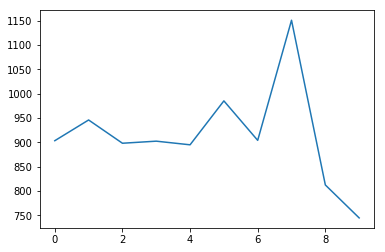

In [12]:
# let's look at the loss history!
plt.plot(loss_history)

In [13]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.14
Epoch 0, loss: 890.760181
Epoch 1, loss: 764.983670
Epoch 2, loss: 773.875989
Epoch 3, loss: 765.402528
Epoch 4, loss: 896.725371
Epoch 5, loss: 762.264798
Epoch 6, loss: 838.216977
Epoch 7, loss: 937.829392
Epoch 8, loss: 1025.340748
Epoch 9, loss: 804.191601
Epoch 10, loss: 868.987493
Epoch 11, loss: 772.364255
Epoch 12, loss: 883.676135
Epoch 13, loss: 854.835761
Epoch 14, loss: 934.344160
Epoch 15, loss: 947.343789
Epoch 16, loss: 890.011718
Epoch 17, loss: 750.828299
Epoch 18, loss: 807.458693
Epoch 19, loss: 837.016183
Epoch 20, loss: 785.130080
Epoch 21, loss: 928.309787
Epoch 22, loss: 750.586186
Epoch 23, loss: 821.967430
Epoch 24, loss: 753.955651
Epoch 25, loss: 832.887913
Epoch 26, loss: 935.561663
Epoch 27, loss: 868.944850
Epoch 28, loss: 924.441853
Epoch 29, loss: 822.405673
Epoch 30, loss: 758.378876
Epoch 31, loss: 826.613832
Epoch 32, loss: 776.784001
Epoch 33, loss: 714.701783
Epoch 34, loss: 992.904736
Epoch 35, loss: 969.975078
Epoch 36, loss: 819.7

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [14]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = 0

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

for learning_rate in learning_rates:
    for reg in reg_strengths:
        clf = linear_classifer.LinearSoftmaxClassifier()
        clf.fit(train_X, train_y, batch_size = batch_size, learning_rate = learning_rate, reg = reg, epochs = num_epochs)
        preds = clf.predict(test_X)
        accuracy = multiclass_accuracy(preds, test_y)
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = clf

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 1058.791530
Epoch 1, loss: 921.819561
Epoch 2, loss: 906.009270
Epoch 3, loss: 935.574475
Epoch 4, loss: 810.916319
Epoch 5, loss: 729.159001
Epoch 6, loss: 963.584631
Epoch 7, loss: 834.966574
Epoch 8, loss: 885.459176
Epoch 9, loss: 823.768559
Epoch 10, loss: 852.002371
Epoch 11, loss: 865.045943
Epoch 12, loss: 680.960302
Epoch 13, loss: 928.722605
Epoch 14, loss: 846.861125
Epoch 15, loss: 642.665519
Epoch 16, loss: 991.607810
Epoch 17, loss: 714.215841
Epoch 18, loss: 669.237357
Epoch 19, loss: 825.653828
Epoch 20, loss: 785.797371
Epoch 21, loss: 696.718140
Epoch 22, loss: 837.881632
Epoch 23, loss: 800.225481
Epoch 24, loss: 939.850529
Epoch 25, loss: 1008.514861
Epoch 26, loss: 738.067841
Epoch 27, loss: 863.485152
Epoch 28, loss: 892.418829
Epoch 29, loss: 903.290335
Epoch 30, loss: 902.729898
Epoch 31, loss: 1003.254446
Epoch 32, loss: 760.474704
Epoch 33, loss: 694.568567
Epoch 34, loss: 1003.369395
Epoch 35, loss: 730.938789
Epoch 36, loss: 656.621223
Epoch 3

Epoch 102, loss: 679.971559
Epoch 103, loss: 947.715470
Epoch 104, loss: 695.773345
Epoch 105, loss: 705.107025
Epoch 106, loss: 812.184457
Epoch 107, loss: 745.433632
Epoch 108, loss: 763.172386
Epoch 109, loss: 787.499800
Epoch 110, loss: 763.033451
Epoch 111, loss: 733.158099
Epoch 112, loss: 754.397266
Epoch 113, loss: 823.817230
Epoch 114, loss: 617.994838
Epoch 115, loss: 970.749417
Epoch 116, loss: 895.646811
Epoch 117, loss: 833.672195
Epoch 118, loss: 749.735366
Epoch 119, loss: 789.519613
Epoch 120, loss: 796.420094
Epoch 121, loss: 712.555426
Epoch 122, loss: 793.530306
Epoch 123, loss: 645.367765
Epoch 124, loss: 648.911543
Epoch 125, loss: 764.981066
Epoch 126, loss: 876.123639
Epoch 127, loss: 825.573088
Epoch 128, loss: 712.428425
Epoch 129, loss: 882.000466
Epoch 130, loss: 843.489554
Epoch 131, loss: 777.154286
Epoch 132, loss: 829.448907
Epoch 133, loss: 777.750523
Epoch 134, loss: 726.125272
Epoch 135, loss: 842.594470
Epoch 136, loss: 798.954628
Epoch 137, loss: 794

Epoch 199, loss: 856.265257
Epoch 0, loss: 685.163770
Epoch 1, loss: 683.986308
Epoch 2, loss: 675.657026
Epoch 3, loss: 669.777871
Epoch 4, loss: 660.724661
Epoch 5, loss: 657.218068
Epoch 6, loss: 656.732152
Epoch 7, loss: 660.242768
Epoch 8, loss: 664.579868
Epoch 9, loss: 652.195705
Epoch 10, loss: 659.008511
Epoch 11, loss: 658.150894
Epoch 12, loss: 648.183066
Epoch 13, loss: 656.414653
Epoch 14, loss: 649.118789
Epoch 15, loss: 648.834453
Epoch 16, loss: 654.877575
Epoch 17, loss: 636.631543
Epoch 18, loss: 645.084869
Epoch 19, loss: 654.405237
Epoch 20, loss: 650.516745
Epoch 21, loss: 646.817951
Epoch 22, loss: 641.848228
Epoch 23, loss: 649.434319
Epoch 24, loss: 648.957964
Epoch 25, loss: 637.331454
Epoch 26, loss: 644.654912
Epoch 27, loss: 647.198103
Epoch 28, loss: 633.782498
Epoch 29, loss: 651.229306
Epoch 30, loss: 645.231165
Epoch 31, loss: 651.420775
Epoch 32, loss: 645.107934
Epoch 33, loss: 650.582266
Epoch 34, loss: 634.639606
Epoch 35, loss: 641.607662
Epoch 36, 

Epoch 100, loss: 645.117222
Epoch 101, loss: 594.870496
Epoch 102, loss: 622.832035
Epoch 103, loss: 638.081989
Epoch 104, loss: 616.658132
Epoch 105, loss: 655.150327
Epoch 106, loss: 621.668051
Epoch 107, loss: 619.134235
Epoch 108, loss: 630.653408
Epoch 109, loss: 611.328579
Epoch 110, loss: 619.170305
Epoch 111, loss: 629.842669
Epoch 112, loss: 618.029925
Epoch 113, loss: 631.497948
Epoch 114, loss: 603.855640
Epoch 115, loss: 618.363221
Epoch 116, loss: 621.060774
Epoch 117, loss: 626.605631
Epoch 118, loss: 635.780550
Epoch 119, loss: 618.470663
Epoch 120, loss: 626.005735
Epoch 121, loss: 623.372079
Epoch 122, loss: 608.727957
Epoch 123, loss: 624.127419
Epoch 124, loss: 638.606996
Epoch 125, loss: 631.606588
Epoch 126, loss: 605.390833
Epoch 127, loss: 626.504131
Epoch 128, loss: 604.456820
Epoch 129, loss: 629.365139
Epoch 130, loss: 635.267010
Epoch 131, loss: 625.728660
Epoch 132, loss: 622.343342
Epoch 133, loss: 629.429444
Epoch 134, loss: 611.428155
Epoch 135, loss: 626

Epoch 197, loss: 603.251252
Epoch 198, loss: 631.075101
Epoch 199, loss: 608.342506
Epoch 0, loss: 690.362222
Epoch 1, loss: 688.978660
Epoch 2, loss: 688.114982
Epoch 3, loss: 687.514888
Epoch 4, loss: 688.148338
Epoch 5, loss: 687.988318
Epoch 6, loss: 684.074371
Epoch 7, loss: 685.999052
Epoch 8, loss: 685.447581
Epoch 9, loss: 683.321261
Epoch 10, loss: 681.958398
Epoch 11, loss: 682.473587
Epoch 12, loss: 683.254499
Epoch 13, loss: 682.130550
Epoch 14, loss: 682.097420
Epoch 15, loss: 680.427152
Epoch 16, loss: 677.151321
Epoch 17, loss: 677.234825
Epoch 18, loss: 678.274245
Epoch 19, loss: 677.157331
Epoch 20, loss: 674.489356
Epoch 21, loss: 675.535336
Epoch 22, loss: 674.067145
Epoch 23, loss: 676.133523
Epoch 24, loss: 674.326114
Epoch 25, loss: 676.652742
Epoch 26, loss: 676.303232
Epoch 27, loss: 671.451010
Epoch 28, loss: 674.700883
Epoch 29, loss: 670.779883
Epoch 30, loss: 677.288669
Epoch 31, loss: 674.838693
Epoch 32, loss: 677.649820
Epoch 33, loss: 673.782631
Epoch 34

Epoch 99, loss: 639.655563
Epoch 100, loss: 656.200755
Epoch 101, loss: 654.854818
Epoch 102, loss: 657.418293
Epoch 103, loss: 656.793783
Epoch 104, loss: 651.550868
Epoch 105, loss: 647.663711
Epoch 106, loss: 653.229907
Epoch 107, loss: 646.843317
Epoch 108, loss: 653.577154
Epoch 109, loss: 660.947735
Epoch 110, loss: 667.644671
Epoch 111, loss: 650.912213
Epoch 112, loss: 636.406861
Epoch 113, loss: 649.376792
Epoch 114, loss: 653.012925
Epoch 115, loss: 641.253335
Epoch 116, loss: 654.138924
Epoch 117, loss: 644.179369
Epoch 118, loss: 665.492092
Epoch 119, loss: 648.941644
Epoch 120, loss: 651.196984
Epoch 121, loss: 651.155982
Epoch 122, loss: 652.971078
Epoch 123, loss: 647.497689
Epoch 124, loss: 648.007691
Epoch 125, loss: 654.185779
Epoch 126, loss: 661.452213
Epoch 127, loss: 651.048175
Epoch 128, loss: 650.863527
Epoch 129, loss: 660.665569
Epoch 130, loss: 646.024435
Epoch 131, loss: 659.978970
Epoch 132, loss: 652.052243
Epoch 133, loss: 650.086365
Epoch 134, loss: 644.

Epoch 196, loss: 634.201615
Epoch 197, loss: 653.656498
Epoch 198, loss: 645.853381
Epoch 199, loss: 653.357135
best validation accuracy achieved: 0.210000


# Какой же точности мы добились на тестовых данных?

In [15]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.210000
